# Tutorial 04: Feasibility Checking Using CommonOcean Vessel Models

The feasibility checker library provides a convenient way to check whether a given trajectory respects the dynamics of a given vessel model. Therefore, we try to compute an input trajectory which allows us to closely match the given state trajectory. We accept the state trajectory as feasible if the error (position and orientation) between the reconstructed and given trajectory is smaller than a predefined error value.
This tutorial demonstrate how the feasibility checker can be used.

## 1 Necessary imports

We first import all necessary files for the feasibility check. In our example, we generate random trajectories for the kinematic single-track model and check those for feasiblity afterwards.

In [2]:
# visualization and numpy
import numpy as np
import matplotlib.pyplot as plt
import copy
import random
import math

from commonocean_dc.feasibility.vessel_dynamics import VesselDynamics

from commonocean.scenario.trajectory import Trajectory
from commonocean.scenario.state import GeneralState
from commonocean.common.solution import VesselType

## 2 Functionalities of the Feasibility Checker

### 2.1 Forward simulation of inputs

Our feasibility checker offers a method for forward simulation of a given input with respect to a vessel model.

In [3]:
# specification of time step and vessel model 
# (PointMass model with Vessel1 parameters)

dt = 1
vessel = VesselDynamics.PM(VesselType.Vessel1)

# create initial zero initial state (all entries are zero)
initial_state = GeneralState(
    position=np.array([0.0, 0.0]),
    velocity=0.0,
    velocity_y=0.0,
    time_step=0
)

# create input with acceleration=1 and acceleration_y=1
input_arr = GeneralState(
    acceleration=0.1,
    acceleration_y=0,
    time_step=0
)

# forward simulation
next_state = vessel.simulate_next_state(initial_state, input_arr, dt)

# compare forward simulation with expected values
expected_pos_x = 0.05
expected_pos_y = 0.0
expected_velocity = 0.1


print('Error in position x: {}'.format(abs(expected_pos_x-next_state.position[0])))
print('Error in position y: {}'.format(abs(expected_pos_y-next_state.position[1])))
print('Error in velocity: {}'.format(abs(expected_velocity-next_state.velocity)))

Error in position x: 1.4753663429845076e-09
Error in position y: 0.0
Error in velocity: 1.3877787807814457e-17


### 2.2 Checking the feasibility of state transitions

Our module can check the feasibility of a given state transition between two given states. To demonstrate the method, we create a random input for the kinematic single track model.

State transition feasible? True


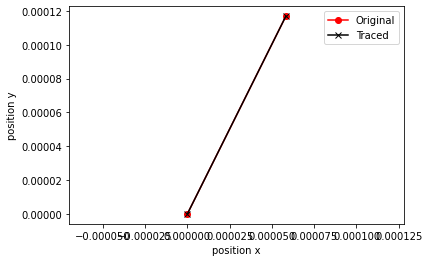

In [4]:
# import the feasibility checker
import commonocean_dc.feasibility.feasibility_checker as feasibility_checker

# specification of time step and vessel model 
# (TF model with Vessel3 parameters)
dt = 0.1
vessel = VesselDynamics.TF(VesselType.Vessel3)

# create initial zero initial state (all entries are zero)
initial_state = vessel.convert_initial_state(
    GeneralState(position=np.array([0.0, 0.0]),
          orientation=0.0,
          velocity=0.0,
          velocity_y=0.0,
          yaw_rate=0.0,
          time_step=0)
)


# create random input for the YP dynamics
input_v = GeneralState(
    force_orientation=random.uniform(-2, 2),
    force_lateral=random.uniform(4, 4),
    yaw_moment=random.uniform(4, 4),
    time_step=0
)


# forward simulation 
next_state = vessel.simulate_next_state(initial_state, input_v, dt)
feasible, reconstructed_input = feasibility_checker.state_transition_feasibility(initial_state, next_state,
                                                                                 vessel, dt)
print('State transition feasible? {}'.format(feasible)) # feasible if error is <= 2e-2

# Reconstruct the next state using the found input
reconstructed = vessel.simulate_next_state(initial_state, reconstructed_input, dt)

# show reconstructed state transition
plt.figure()
plt.plot([initial_state.position[0],next_state.position[0]],
         [initial_state.position[1],next_state.position[1]],'-or')
plt.plot([initial_state.position[0],reconstructed.position[0]],
         [initial_state.position[1],reconstructed.position[1]],'-xk')
plt.axis('equal')
plt.xlabel('position x')
plt.ylabel('position y')
plt.legend(['Original','Traced'])
plt.show()


### 2.3 Checking the feasibility of trajectories

Our module can check the feasibility of a given trajectory by iteratively calling the state transition check for each pair of states of the trajectory. To demonstrate the method, we create a random trajectory for the kinematic single track model.

In [5]:
# specification of time step and vessel model 
# (YP model with Vessel1 parameters)

dt = 0.1
vessel = VesselDynamics.YP(VesselType.Vessel1)

# create initial zero initial state (all entries are zero)
initial_state = GeneralState(position=np.array([0.0, 0.0]),
          orientation=0.0,
          velocity=0.0,
          time_step=0)

# create random input vector and the trajectory (20 timesteps)
states = [vessel.convert_initial_state(initial_state)]
inputs = []
time_step = 0
while len(inputs) < 20:
    # create a random input

    inp = GeneralState(acceleration=random.uniform(-0.2, 0.2),
    yaw_rate=random.uniform(-0.4, 0.4),
    time_step=time_step)
    
    
    # if valid input, simulate next state
    next_state = vessel.simulate_next_state(states[-1], inp, dt, throw=False)
    states.append(next_state)
    inputs.append(inp)
    time_step += 1


# create trajectory and input vector
input_vector = Trajectory(initial_time_step=0, state_list=inputs)
trajectory = Trajectory(initial_time_step=0, state_list=states)

# check feasibility of trajectory
feasible, reconstructed_inputs = feasibility_checker.trajectory_feasibility(trajectory, vessel, dt)

# reconstruct the trajectory using the reconstructed input vector inputs step wise
reconstructed_states = [vessel.convert_initial_state(initial_state)] + [
    vessel.simulate_next_state(trajectory.state_list[idx], inp, dt)
    for idx, inp in enumerate(reconstructed_inputs.state_list)
]
trajectory_reconstructed = Trajectory(initial_time_step=0, state_list=reconstructed_states)

# reconstucting the trajectory using the reconstructed input vector directly is also possible, but
# it will create a trajectory that is similar but different to the real trajectory due to the small
# errors between the real inputs and the approximated inputs.

# trajectory_reconstructed = vessel.simulate_trajectory(initial_state, reconstructed_inputs, dt)

# print and analyze result
print('Feasible? {}'.format(feasible))

error_state = len(trajectory_reconstructed.state_list)
if not feasible:
    print('Error found at state transition {} to {}'.format(error_state-2,error_state-1))

Feasible? True


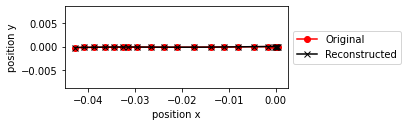

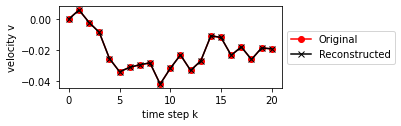

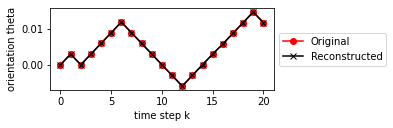

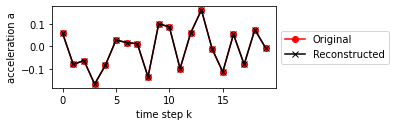

In [6]:
## Plot Figures
fsize = (4,1.5)

# position figure
orig_pos = np.array([x.position for x in trajectory.state_list])
recon_pos = np.array([x.position for x in trajectory_reconstructed.state_list])

plt.figure(figsize=fsize)
plt.plot(orig_pos[:,0],orig_pos[:,1],'-or')
plt.plot(recon_pos[:,0],recon_pos[:,1],'-xk')
plt.legend(['Original','Reconstructed'],loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('position x')
plt.ylabel('position y')
plt.axis('equal')
plt.autoscale()
plt.show()

# velocity figure
orig_velocity = np.array([[x.time_step, x.velocity] for x in trajectory.state_list])
recon_velocity = np.array([[x.time_step, x.velocity] for x in trajectory_reconstructed.state_list])

plt.figure(figsize=fsize)
plt.plot(orig_velocity[:,0],orig_velocity[:,1],'-or')
plt.plot(recon_velocity[:,0],recon_velocity[:,1],'-xk')
plt.xlabel('time step k')
plt.ylabel('velocity v')
plt.legend(['Original','Reconstructed'],loc='center left', bbox_to_anchor=(1, 0.5))
plt.autoscale()
plt.show()

# orientation figure
orig_orientation = np.array([[x.time_step, x.orientation] for x in trajectory.state_list])
recon_orientation = np.array([[x.time_step, x.orientation] for x in trajectory_reconstructed.state_list])

plt.figure(figsize=fsize)
plt.plot(orig_orientation[:,0],orig_orientation[:,1],'-or')
plt.plot(recon_orientation[:,0],recon_orientation[:,1],'-xk')
plt.legend(['Original','Reconstructed'],loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('time step k')
plt.ylabel('orientation theta')
plt.autoscale()
plt.show()

# acceleration figure
orig_acc = np.array([[u.time_step, u.acceleration] for u in input_vector.state_list])
recon_acc = np.array([[u.time_step, u.acceleration] for u in reconstructed_inputs.state_list])

plt.figure(figsize=fsize)
plt.plot(orig_acc[:,0],orig_acc[:,1],'-or')
plt.plot(recon_acc[:,0],recon_acc[:,1],'-xk')
plt.legend(['Original','Reconstructed'],loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('time step k')
plt.ylabel('acceleration a')
plt.autoscale()
plt.show()
